In [1]:
from __future__ import division
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
""" Reading data"""

train_x = np.load('exam2_train_x.npy', mmap_mode='r')
train_y = np.load('exam2_train_y.npy', mmap_mode='r')
test_x = np.load('exam2_test_x.npy', mmap_mode='r')
test_y = np.load('exam2_test_y.npy', mmap_mode='r')

"""normalising data_x"""
train_x_norm = (train_x / 255) - 0.5
test_x_norm = (test_x / 255) - 0.5

train_y_reshape = train_y.reshape(1020,1)
test_y_reshape = test_y.reshape(180, 1)


#print(data_y1.shape)
print(train_x_norm.shape)
print(train_y_reshape.shape)
print(test_x.shape)

(1020, 64, 64, 3)
(1020, 1)
(180, 64, 64, 3)


In [3]:
"""Function for One hot encoding. input Y as an array and no.of samples is passed to the function"""

def One_Hot_Encoding(arr, samples_num):
    encode_matrix = np.zeros((samples_num, 6))
    for i in range(samples_num):
        encode_matrix[i][arr[i][0]] = 1
    return encode_matrix

In [4]:
""" applying one-hot encoding on train and test y"""

train_y_encode = One_Hot_Encoding(train_y_reshape, len(train_y_reshape))
test_y_encode = One_Hot_Encoding(test_y_reshape, len(test_y_reshape))

In [5]:
print(train_y_encode.shape)
print(test_y_encode.shape)

(1020, 6)
(180, 6)


In [10]:
"""forward propagation. convolution and fully connected. dropout is applied as regularization for fully conencted layers"""

def frwd_propagation(X_input, weights, bias):
      
    
    W1, W2 = weights
    B1, B2 = bias
    # first convolution with relu as activation
    conv1 = tf.nn.conv2d(X_input, W1, strides = [1,2,2,1], padding = 'SAME')
    print("conv1 layer shape")
    print(conv1.shape)
    Z1 = tf.nn.bias_add(conv1, B1)
    A1 = tf.nn.relu(Z1)
    #max pooling
    pool1 = tf.nn.max_pool(A1, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    print("pool1 shape")
    print(pool1.shape)
    # 2nd convolution layer with relu as activation
    conv2 = tf.nn.conv2d(pool1, W2, strides = [1,2,2,1], padding = 'SAME')
    Z2 = tf.nn.bias_add(conv2, B2)
    A2 = tf.nn.relu(Z2)
    print("conv2 shape")
    print(conv2.shape)
    #avg pooling
    #Pool2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,1,1,1], padding = 'SAME')
    pool2 = tf.nn.avg_pool(A2, ksize = [1,4,4,1], strides = [1,1,1,1], padding = 'SAME', data_format='NHWC', name=None)
    print("pool2 shape before unfaltten")
    print(pool2.shape)
    pool2 = tf.contrib.layers.flatten(pool2)
    print("pool2 shape after flatten")
    print(pool2.shape)
    #fully connected layer relu as activation
    Z3 = tf.contrib.layers.fully_connected(pool2, 108, activation_fn=None)
    A3 = tf.nn.relu(Z3)
    #dropout regularization
    drop_out_A3 = tf.nn.dropout(A3, 0.95)
    Z4 = tf.contrib.layers.fully_connected(drop_out_A3, 6, activation_fn=None)
    A4 = tf.nn.sigmoid(Z4)
    
    

    return A4

In [11]:
"""function to initialize weights and bias for convolution 2 layers"""
def initialize_weights():
    
    tf.set_random_seed(1)                              
        
    W1 = tf.get_variable('W1',[4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[4, 4, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    B1 = tf.zeros([8], tf.float32)
    B2 = tf.zeros([16], tf.float32)
    weights = ( W1, W2)
    bias = ( B1,  B2)
    
    return weights, bias

In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.002, iterations = 100, minibatch_size = 60):

    tf.set_random_seed(1)                                                                       
    (m, n_h, n_w, n_c) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = [] 
    seed = 3
    weights, bias = initialize_weights()
    W1, W2 = weights
    X = tf.placeholder(tf.float32, shape=[None, n_h, n_w, n_c])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    #forward propagation
    Z4 = frwd_propagation(X, weights, bias)
    #calcualting cost
    cost_total = tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y)
    #l2 regularization
    #regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    #cost = tf.reduce_mean(cost_total + 0.001 * regularizer)
    cost = tf.reduce_mean(cost_total )
    #back propagation
    adamoptimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for iteration in range(iterations):
            
            cost_min_batch = 0
            seed = seed + 1
            
            minbatches = generate_min_batch(X_train, Y_train, seed, minibatch_size)
            minbatch_num = int(m / minibatch_size)
            for batch in minbatches:

                (min_batch_X, min_batch_Y) = batch
                _ , cost_single_batch = sess.run([adamoptimizer, cost], feed_dict={X: min_batch_X, Y: min_batch_Y})
                cost_min_batch += cost_single_batch / minbatch_num
                
            #if iteration % 5 == 0:
                #print("cost is %s " %cost_min_batch)
            
            if iteration % 1 == 0:
                costs.append(cost_min_batch) 

        # Calculate correct predictions
        predict_y = tf.argmax(Z4, 1)
        correct_prediction = tf.equal(predict_y, tf.argmax(Y, 1))
        
        # Calculate accuracy on the TRAIN SET AND test set
        accuracy = 100 * tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        #new_y = predict_y.eval({X: X_train, Y: Y_train})
        #print(new_y)
                
        return train_accuracy, test_accuracy, weights, bias, costs

In [13]:
def generate_min_batch(X_train, Y_train, seed, minbatch_size):
    m = X_train.shape[0]
    #print("this is m %s" %m)
    np.random.seed(seed)
    random_p = np.random.permutation(m)
    #print("permutaion %s " %random_p)
    X_shuffled = X_train[random_p, :]
    Y_shuffled = Y_train[random_p, :]
    
    num_min_batches = m/minbatch_size
    min_batches = []
    for i in range(0, int(num_min_batches)):
        batch_X = X_shuffled[i * minbatch_size:(i + 1) * minbatch_size, :]
        batch_Y = Y_shuffled[i * minbatch_size:(i + 1) * minbatch_size, : ] 
        min_full_batch = (batch_X, batch_Y)
        min_batches.append(min_full_batch)
    
    return min_batches
    

In [14]:
from datetime import datetime
start=datetime.now()
train_accuracy, test_accuracy, weights, bias, costs = model(train_x_norm, train_y_encode, test_x_norm, test_y_encode)
end = datetime.now() - start
#print(end)

C:\Users\sahitya\Anaconda2\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


conv1 layer shape
(?, 32, 32, 8)
pool1 shape
(?, 32, 32, 8)
conv2 shape
(?, 16, 16, 16)
pool2 shape before unfaltten
(?, 16, 16, 16)
pool2 shape after flatten
(?, 4096)
Train Accuracy: 99.80392
Test Accuracy: 95.0


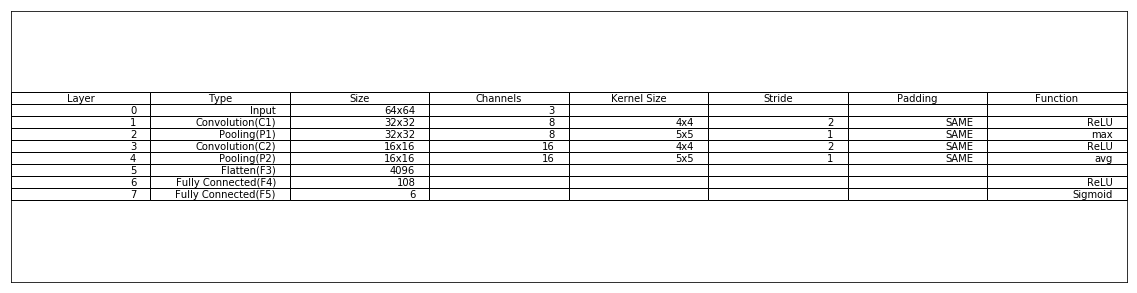

In [15]:
"""architecture -tabular representation"""

fig, ax = plt.subplots(figsize=(20, 5))

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)


data = [['0', 'Input', '64x64', '3', '', '', '', ''], ['1', 'Convolution(C1)', '32x32', '8', '4x4', '2', 'SAME', 'ReLU'],
           ['2', 'Pooling(P1)', '32x32', '8', '5x5', '1', 'SAME', 'max'],
           ['3', 'Convolution(C2)', '16x16', '16', '4x4', '2', 'SAME', 'ReLU'],
           ['4', 'Pooling(P2)', '16x16', '16', '5x5', '1', 'SAME', 'avg'],
           ['5', 'Flatten(F3)', '4096', '', '', '', '', ''],
           ['6', 'Fully Connected(F4)', '108', '', '', '', '', 'ReLU' ],
           ['7', 'Fully Connected(F5)', '6', '', '', '', '', 'Sigmoid']
          ]
collabel=("Layer", "Type", "Size", "Channels", "Kernel Size", "Stride", "Padding", "Function" )
ax.table(cellText=data,colLabels=collabel,loc='center')

Text(0,0.5,'cost')

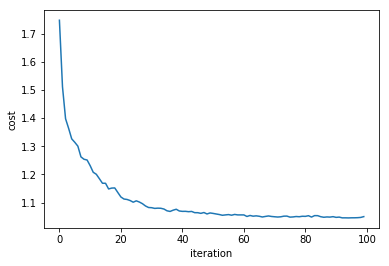

In [16]:
iteration = range(0, 100)
plt.plot(iteration, costs)
plt.xlabel("iteration")
plt.ylabel("cost")

In [17]:
print("Train accuracy of the model is %s" %train_accuracy)
print("Test accuracy of the model is %s " %test_accuracy)

Train accuracy of the model is 99.80392
Test accuracy of the model is 95.0 
